In [1]:
library(forecast)
library(tseries)
library(ggplot2) 
library(reshape) # 데이터 재구조화
library(zoo)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## 시계열분석 방법

1. **STL (Seasonal Trend Decomposition Using Loess)**
- Seasonal과 Trend를 분해하고 다항식을 이용하여 예측

2. **지수평활**
- 단순 지수 평활
- 이중 지수 평활
- Holt-Winters

3. **ARIMA**

# Data Load

In [2]:
#============================================================
# Data Load
# - 1949년 ~ 1960년 까지의 월별 비행기 탑승 고객 수
#============================================================ 
origin <- AirPassengers
origin

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336
1958,340,318,362,348,363,435,491,505,404,359,310,337


In [4]:
class(origin) # ts 객체

[1] "ts"

In [5]:
start(origin)
end(origin)
frequency(origin)

[1] 1949    1

[1] 1960   12

[1] 12

# EDA

- 시도표: 한 축에는 시간을, 다른 축에는 관측치를 놓은 Line Plot.

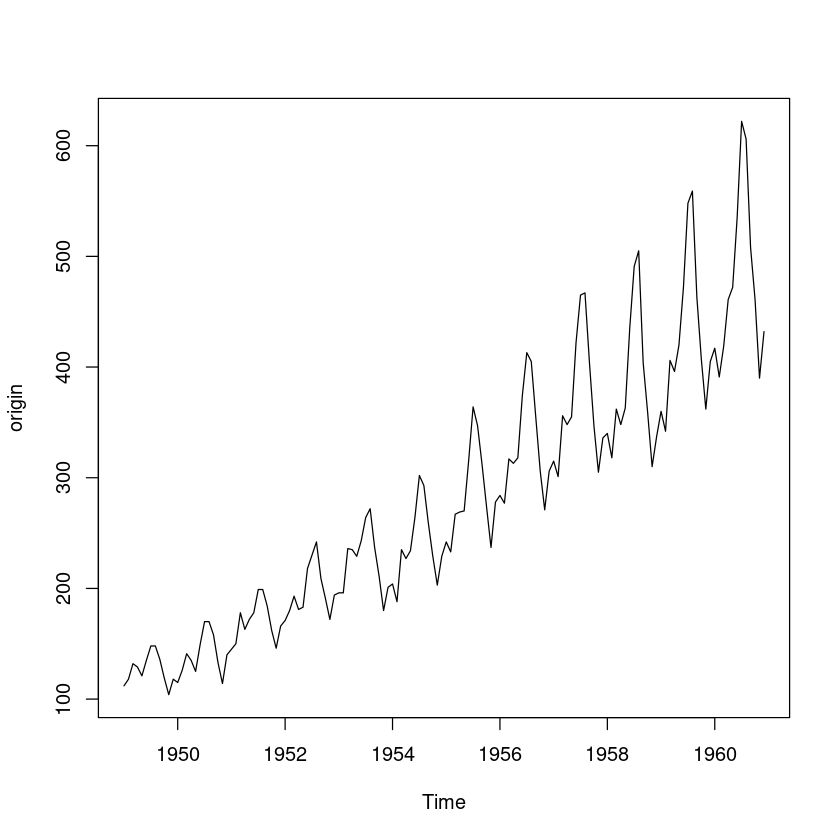

In [8]:
# 시도표
plot(origin)
# 데이터에 이분산이 존재함을 확인일 수 있음
# 분산 안정화를 위한 데이터 변환 필요

- **Boxcox먼저 (등분산) , seasonal, 차분, 계절차분 순서 중요!**

시즈널, 트렌드, 분산이상한데 분산맞춰주는게 우선.

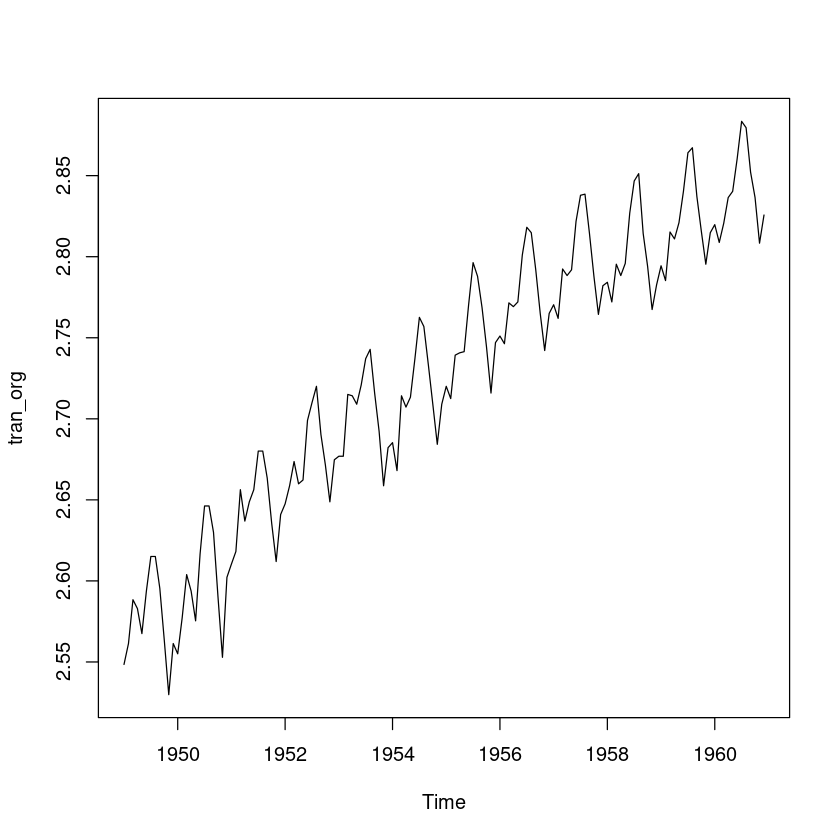

In [9]:
#분산 안정화를 위한 BoxCox 변환
lambda <- BoxCox.lambda(origin)
tran_org <- BoxCox(origin, BoxCox.lambda(origin))
plot(tran_org)
# BoxCox 변환 이후 이분산의 효과가 줄어 든것을 확인

In [10]:
BoxCox.lambda(origin)

[1] -0.2947156

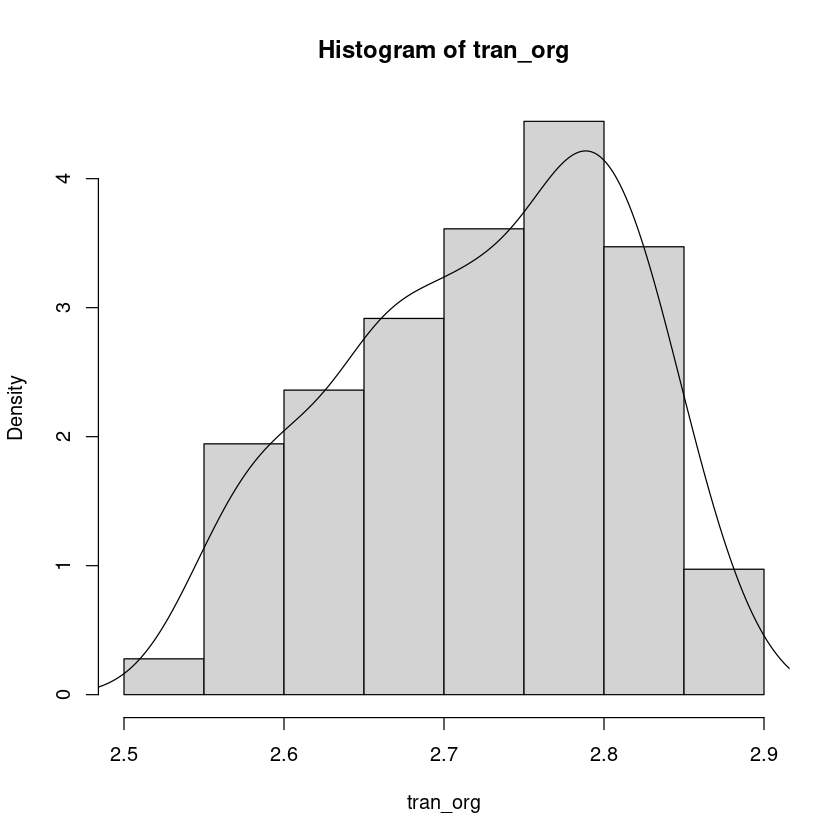

In [11]:
## 질문?
# 정규성 및 Corr
# Hist Plot
hist(tran_org,prob=TRUE,12)
lines(density(tran_org))

**QQ Plot, 정규성 검정 $\to$ 왜하는지?**

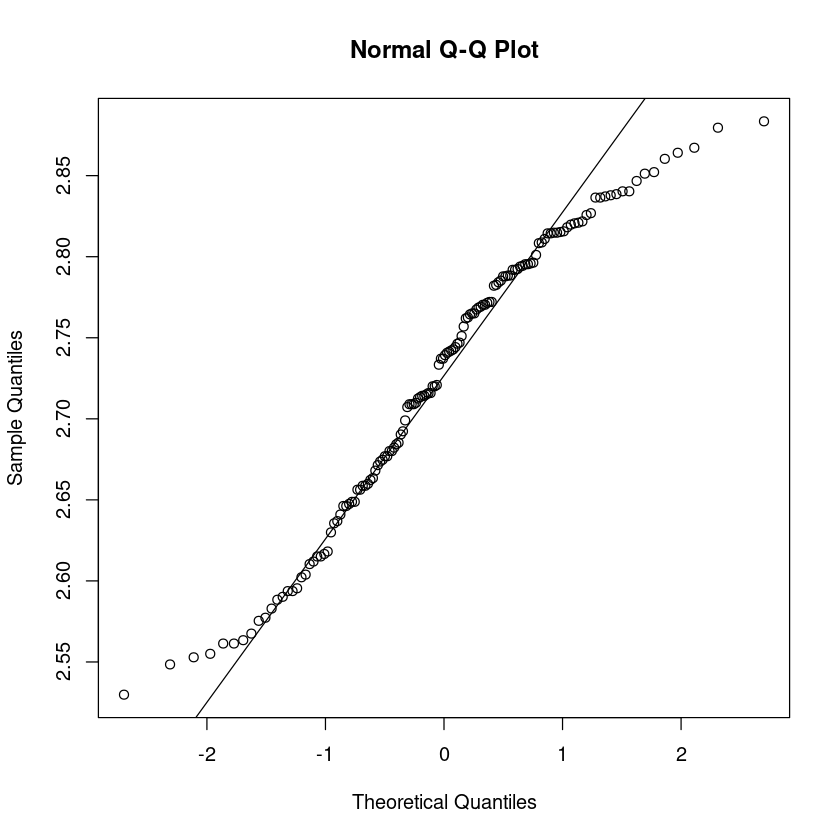

In [12]:
# Q-Q PLOT
qqnorm(tran_org)
qqline(tran_org)

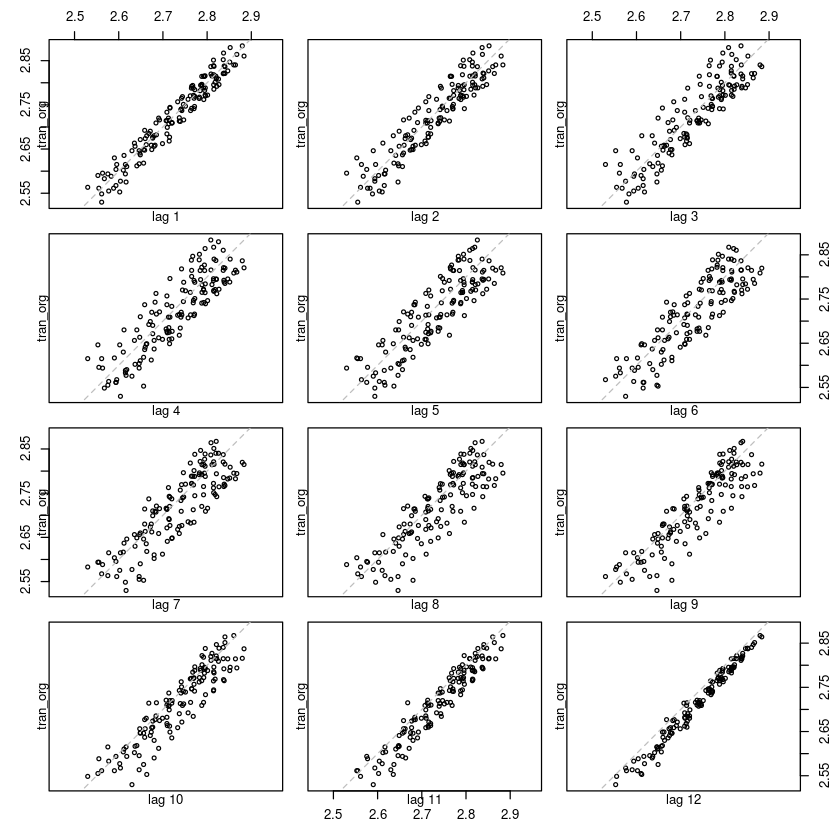

In [15]:
# 상관관계 확인
lag.plot(tran_org,12,do.lines=FALSE)
#전반적으로 데이터는 정규분포를 따르고 시차가 12일때 상관관계가 높음

`-` 원래는 아래와 같이 해야한다. 

1. 

In [55]:
## lag =1 

In [56]:
n=length(y)
lag = 1 
corrs <- c()
for(lag in 1:15){
corrs[lag] <- cor(y[1:(144-lag)],y[(1+lag):144])
}

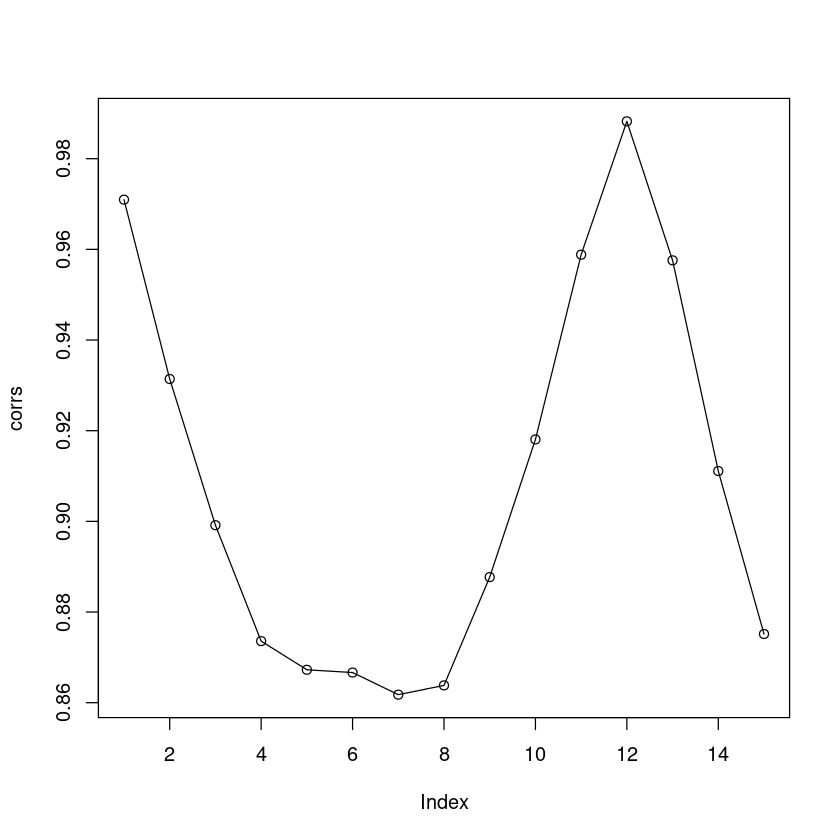

In [57]:
plot(corrs,type='o')

- 산점도가 직선일 경우에만 coef 가 의미가 있으므로 이는 문제가 생김 

`-` ACF를 보는 경우 

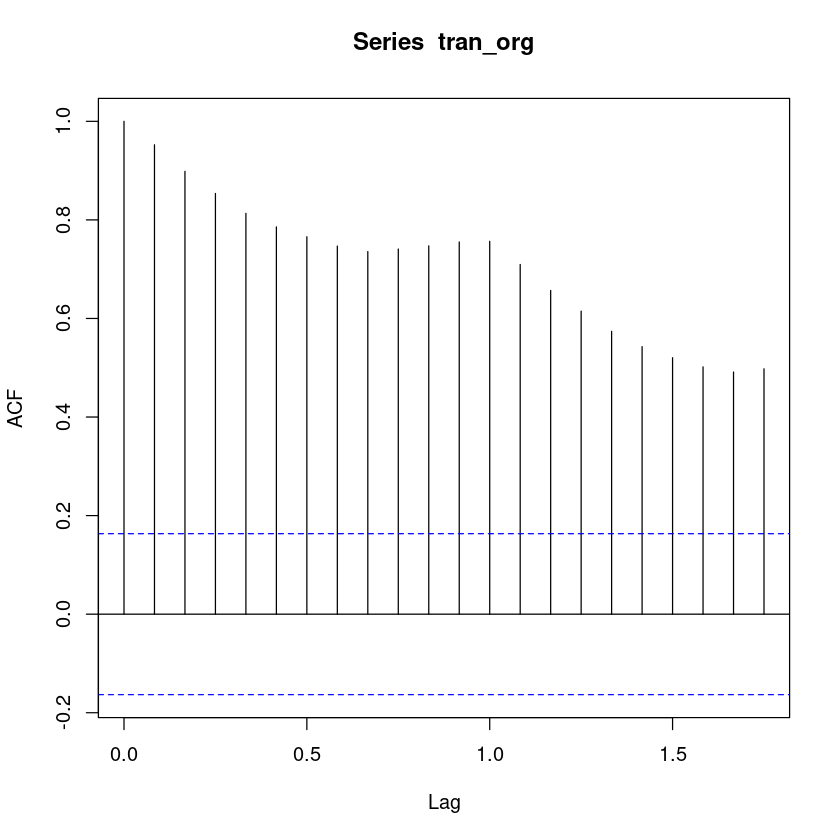

In [63]:
acf(tran_org)

- 해석: 만약에 lag=12에 해당하는 coef 가 0이라면 일정하게 감소해야하는데, lag=12에서 반등 -> $y_t$와 $y_{t-12}$와 상관관계 존재 -> $y_{t},y_{t-12},y_{t-24}$ 와도 관계가 있음 -> 주기가 존재 (12)

- 단점: 보기 불편

`-` $y_t$와 $y_{t-1}$의 상관성이 강한편이라. 이러한 상관관계가 lag에 따라서 물려지므로 ($y_t$와 $y_{t-1}$이 0.9의 상관관계를 가진다면 $y_{t}$와 $y_{t-2}$의 직접적 상관관계가 없어도 0.81이 계산됨) 차분을 한뒤에 ACF를 관찰할 수 있음 

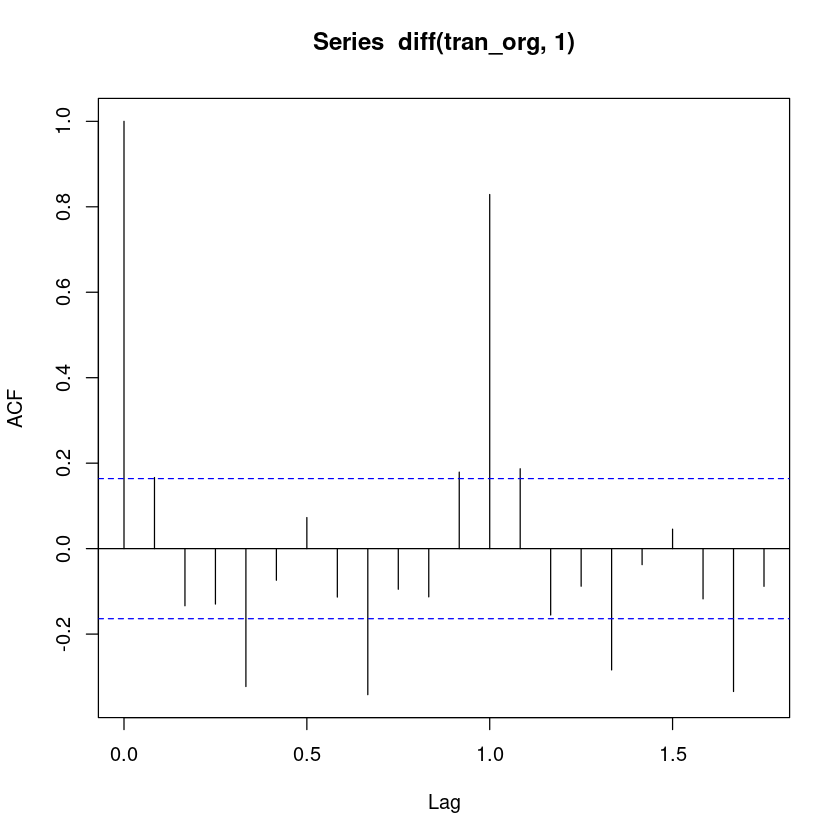

In [64]:
acf(diff(tran_org,1))

- 해석: 차분한뒤에는 lag=12에서 상관관계가 뚜렷 -> 주기가 12임을 추측 -> SARIMA에서 이런식으로 주기잡아냄

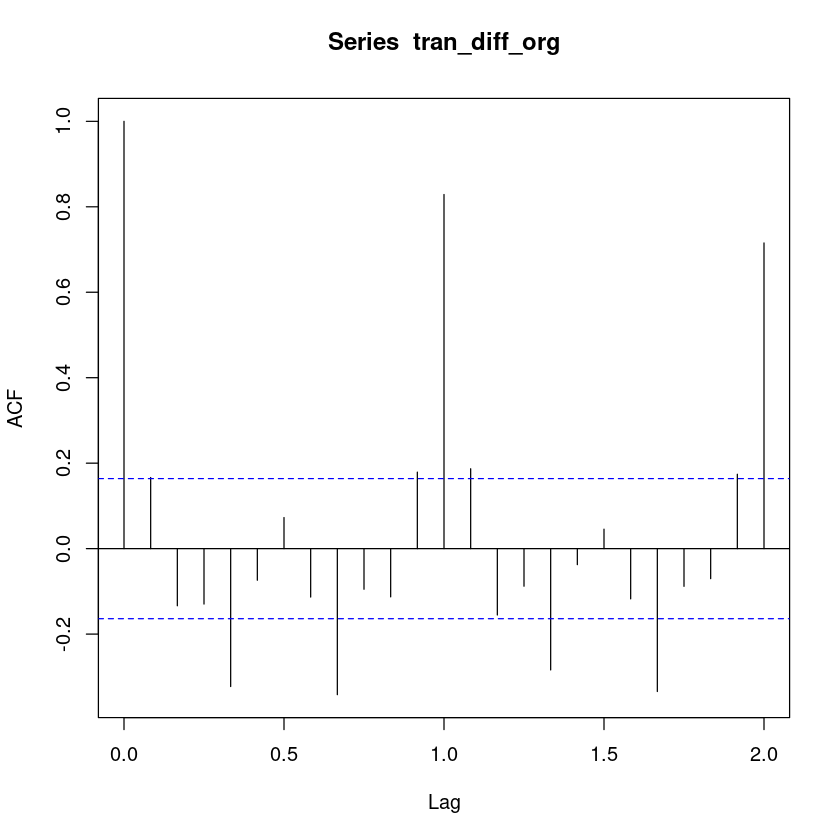

In [67]:
acf(tran_diff_org, lag.max = 24) # sarima에서 가져온 코드

-- 이러한 방식의 해석을 SARIMA에서 함

- 만약에 lag=12에 해당하는 coef 가 0이라면 일정하게 감소해야하는데, lag=12에서 반등 -> $y_t$와 $y_{t-12}$와 상관관계 존재 -> $y_{t},y_{t-12},y_{t-24}$ 와도 관계가 있음 -> 주기가 존재 (12)

# 시계열 분해 및 회귀분석 이용 예측

$y_t = season_t + trend_t  + noise$

와 같다고 가정하자. 

우리가 ARMA통해서 맞출수있는건 noise 뿐임

season + trend가 있으면 non-stationary timse serise이므로 ARMA로 분석X 

- trend를 제거하기위해서는 차분이 사용 
- season을 제거하기 위해서는 계절차분을 사용
- 그런데 분해방법을 이용하면, 차분과 계절차분을 쓰지 않고도 season , trend를 제거할 수 있음. 

결국 만약에 $y_t$를 입력으로 넣으면 출력이 $season_t, trend_t, noise$로 알아서 data-adative 하게 나오게 만드는 장치가 있다면,차분과 계절차분을 사용하지 않아도 무방

- 비정상시계열의 ACF, PACF 를 판단하면서 lag을 얼마로 차분할지 계절차분할지 순서는어떻게할지 등을 고민할 필요 X 

그 장치가 `stl`

In [98]:
stl_tran_org <- stl(tran_org, s.window = 12) # --주기를 12로 잡은 근거는 위에있음

결과로 stl_tran_org 이게 있음 

In [101]:
y1= as.data.frame(stl_tran_org$time.series)$seasonal # 계절성분
y2= as.data.frame(stl_tran_org$time.series)$trend # 트렌드
y3= as.data.frame(stl_tran_org$time.series)$remainder # s노이즈

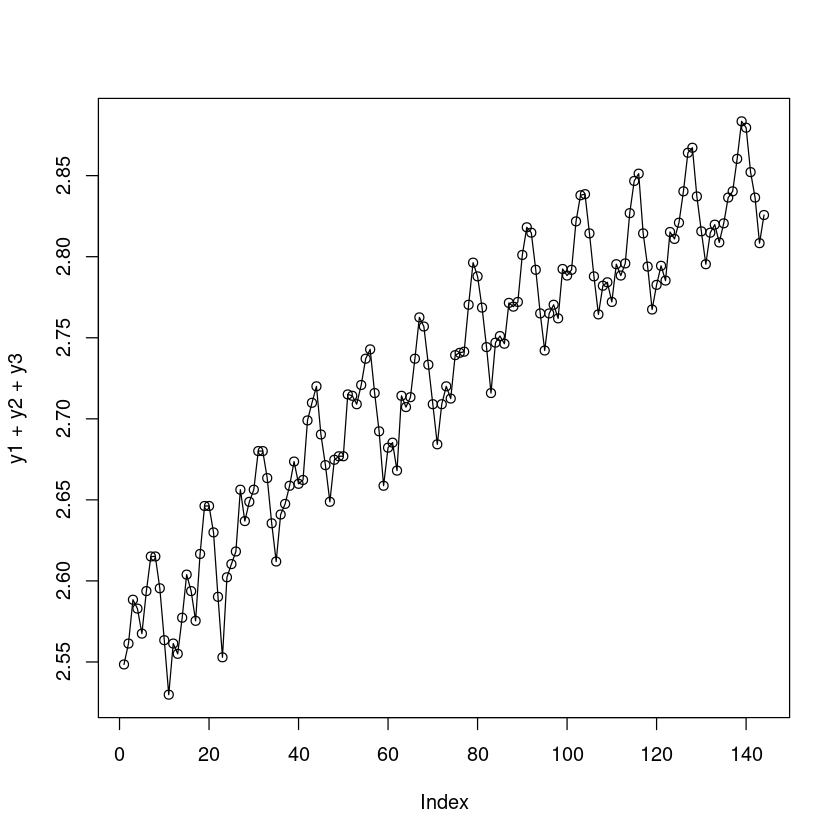

In [108]:
plot(y1+y2+y3)
lines(y)

In [109]:
# plot(stl_tran_org)
# # 1차 Trend와 Seasonality 존재
# # 잔차는 White Noise로 판단

만약에 $y3$가 ARMA같으면 그냥 분석해도 무방

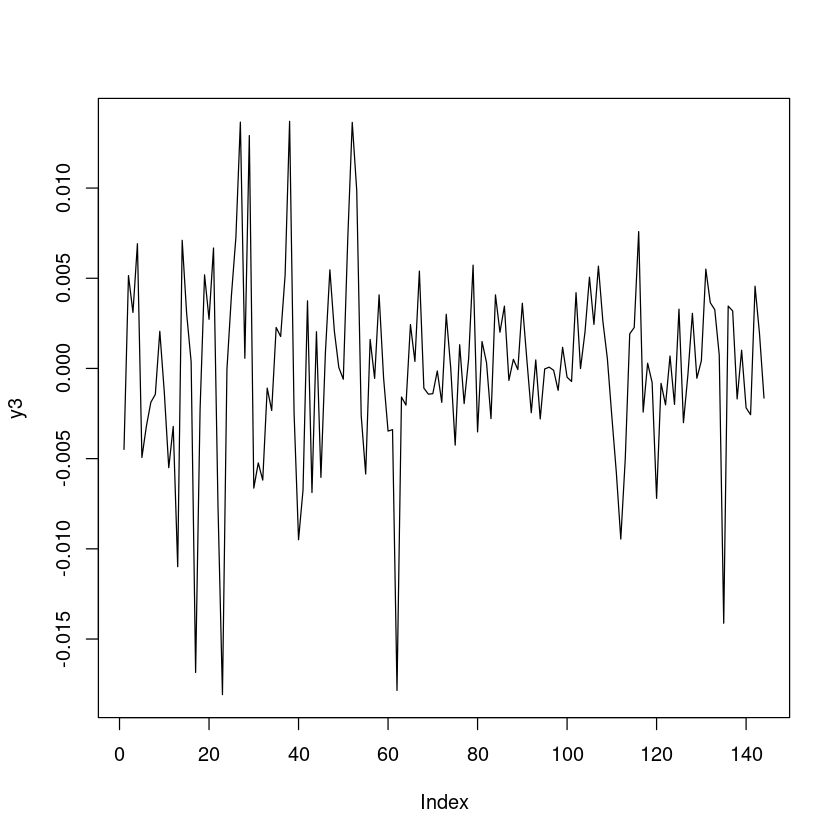

In [111]:
plot(y3,type='l')

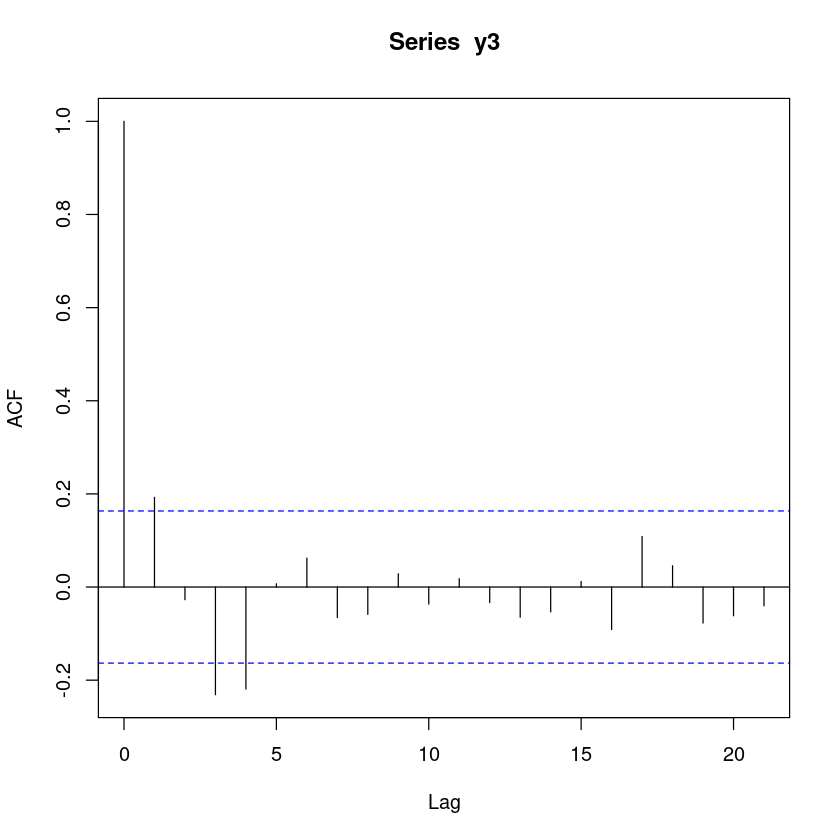

In [113]:
acf(y3)

- 이걸 MA(4)로 피팅해도 무방

방법1: $Y_t =T_t + S_t+ {\tt 오차항은 정규로가정}$

**방법2**: $Y_t= T_t+{\tt 계절성을 모델링하는 더미변수}+{\tt 오차항은 정규가정}$

방법3: $Y_t= S_t+{\tt 시간에 비례하는 선형트렌드가정} + {\tt 오차항은 정규가정}$

In [129]:
y1_ = 2*1:100/100
y2_ = 3*1:100/100+3
y_ = c(y1_,y2_)

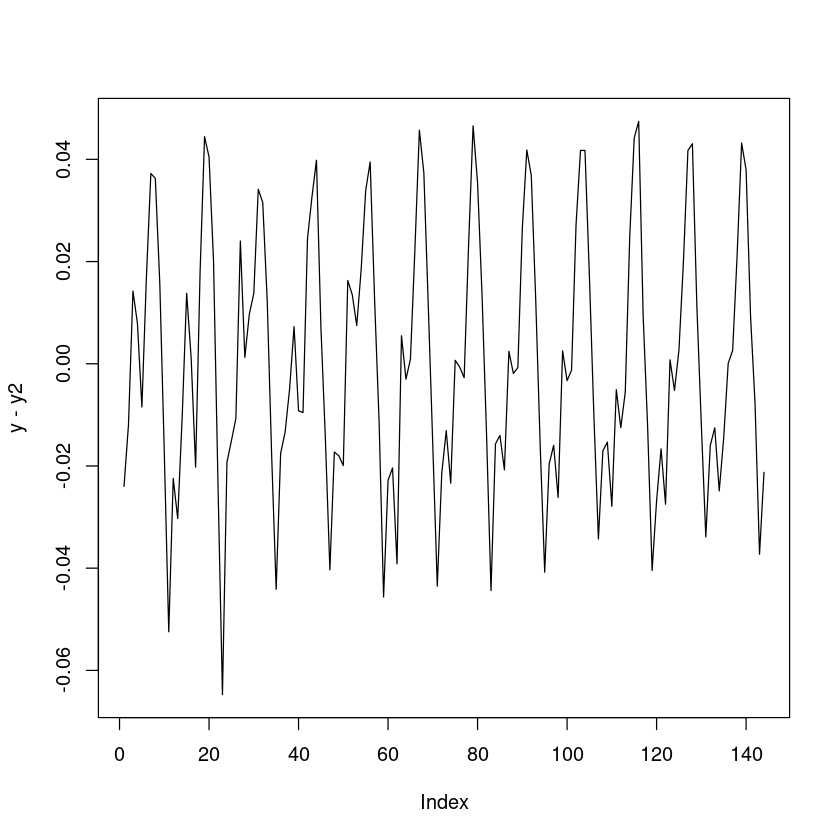

In [131]:
plot(y-y2,type='l') # 이것을 회귀분석 
# y = Y_t-T_t 
# x = 1월에 해당하는 더미변수 + ...+ 12월에 해당하는 더미변수 
# 오차항 = 정규

`-` 이중에서 trend를 이용 + season은 버림 // season은 따로 모델링

In [28]:
# 계절형 Dummy 변수 생성
M <- factor(cycle(tran_org))
stl_tran_org_df <- as.data.frame(stl_tran_org$time.series)

In [196]:
# 회귀 모형 생성
# 모형식 : tran_org=trend∗β1+M1∗d1+...+M11∗d11+ϵ
model_stl <- lm(formula = tran_org~0+stl_tran_org_df$trend+M, na.action = NULL)
summary(model_stl)


Call:
lm(formula = tran_org ~ 0 + stl_tran_org_df$trend + M, na.action = NULL)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0208982 -0.0030056  0.0003675  0.0032375  0.0186285 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
stl_tran_org_df$trend  1.003132   0.006557 152.982  < 2e-16 ***
M1                    -0.025890   0.017899  -1.446  0.15043    
M2                    -0.029141   0.017911  -1.627  0.10614    
M3                    -0.002850   0.017923  -0.159  0.87389    
M4                    -0.009503   0.017936  -0.530  0.59713    
M5                    -0.010617   0.017948  -0.592  0.55519    
M6                     0.012901   0.017961   0.718  0.47386    
M7                     0.032071   0.017974   1.784  0.07669 .  
M8                     0.030402   0.017986   1.690  0.09335 .  
M9                     0.004045   0.017998   0.225  0.82255    
M10                   -0.023032   0.018011  -1.279  0.20322    
M11          

tran_org 에서 이미 $\hat{\beta}_0+ \hat{\beta}_1x_i$ 의 성분은 추정되었다고 가정하였으므로 

```R
model_stl <- lm(formula = tran_org~stl_tran_org_df$trend+M, na.action = NULL)
```

이 아니라

```R
model_stl <- lm(formula = tran_org~0+stl_tran_org_df$trend+M, na.action = NULL)
```

을 사용하는 것임 

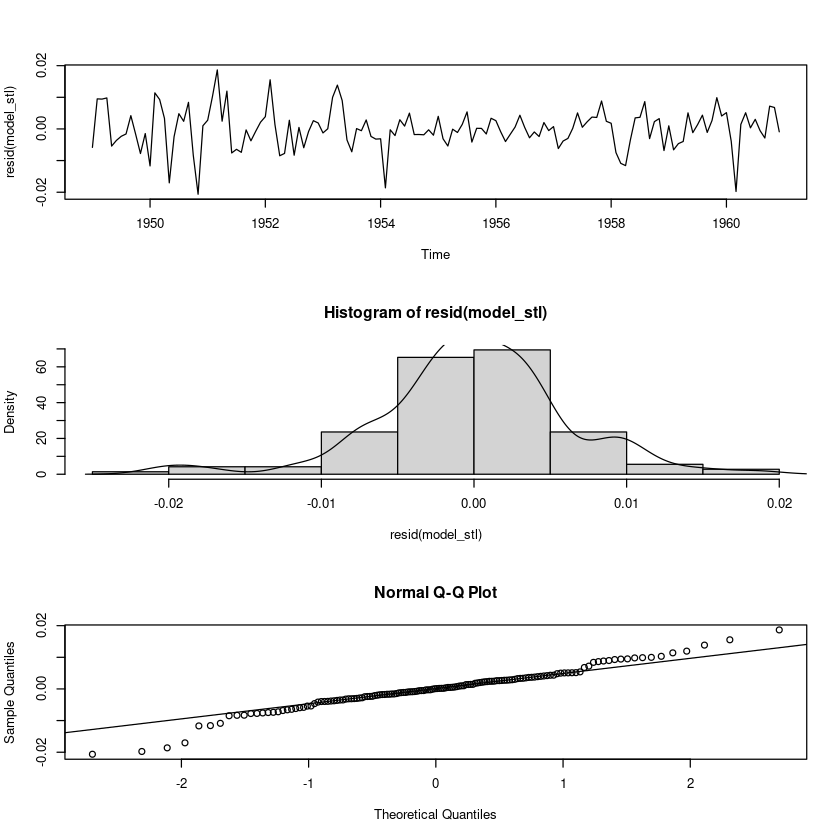

In [193]:
# 잔차 검정
par(mfrow=c(3,1))
# time Plot
plot(resid(model_stl))
# Hist Plot
hist(resid(model_stl),prob=TRUE,12)
lines(density(resid(model_stl)))
# Q-Q PLOT
qqnorm(resid(model_stl))
qqline(resid(model_stl))
# Q-Q Plot과 Histogram을 확인하면 양쪽 끝이 두텁지만 White Noise라고 판단하기 어려움이 없음


- 트렌드 분산 같이 잡고싶을 때

[1] 81.13464

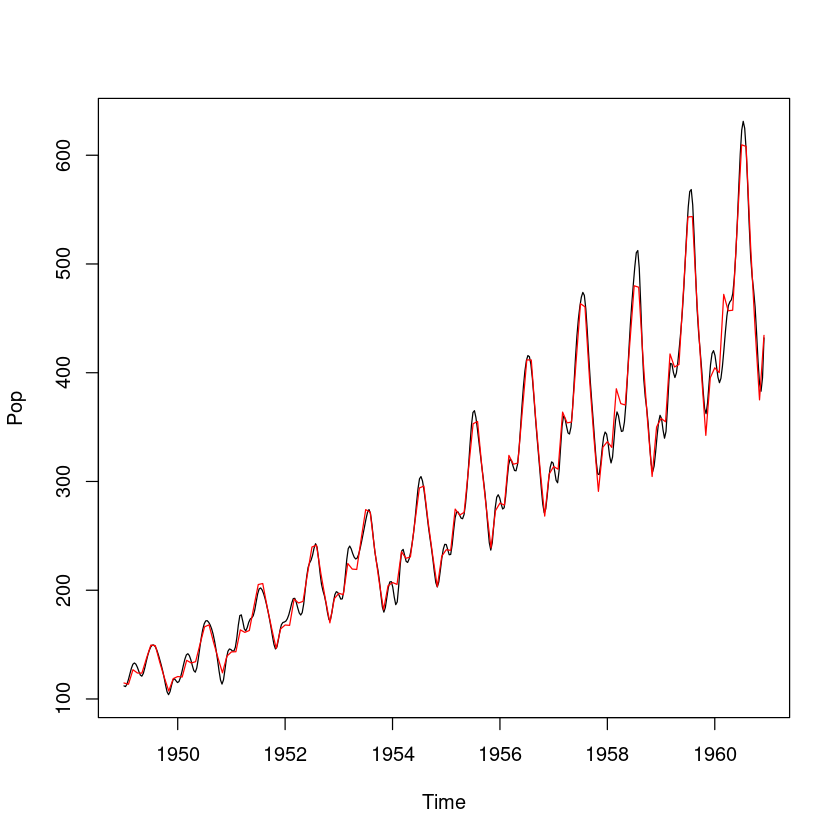

In [194]:
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

# 원 데이터 및 fitted 데이터의 비교
# BoxCox 역변환 필요 함
lines(InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)), col='red')
mean((origin - InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)))^2, na.rm = TRUE)

`-` 방법1

In [182]:
# 회귀 모형 생성
# 모형식 : tran_org=trend∗β1+M1∗d1+...+M11∗d11+ϵ
model_stl <- lm(formula = tran_org~ 0+stl_tran_org_df$trend+stl_tran_org_df$seasonal, na.action = NULL)
summary(model_stl)


Call:
lm(formula = tran_org ~ 0 + stl_tran_org_df$trend + stl_tran_org_df$seasonal, 
    na.action = NULL)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0176596 -0.0024179  0.0002433  0.0028433  0.0138835 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
stl_tran_org_df$trend    0.9999916  0.0001588 6298.75   <2e-16 ***
stl_tran_org_df$seasonal 1.0086463  0.0178343   56.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005194 on 142 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.984e+07 on 2 and 142 DF,  p-value: < 2.2e-16


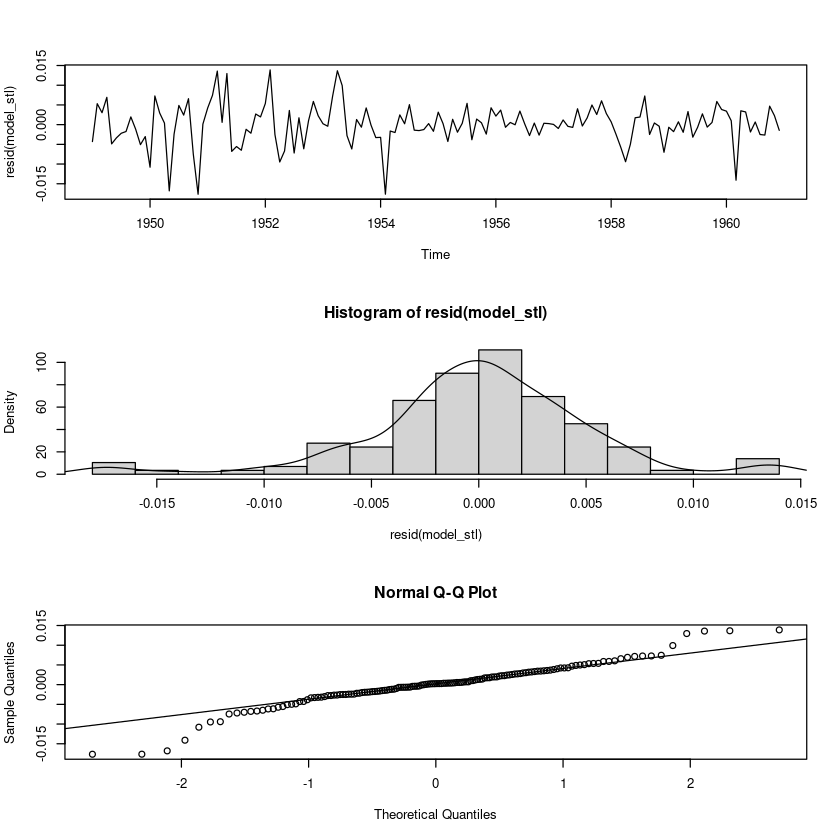

In [183]:
# 잔차 검정
par(mfrow=c(3,1))
# time Plot
plot(resid(model_stl))
# Hist Plot
hist(resid(model_stl),prob=TRUE,12)
lines(density(resid(model_stl)))
# Q-Q PLOT
qqnorm(resid(model_stl))
qqline(resid(model_stl))
# Q-Q Plot과 Histogram을 확인하면 양쪽 끝이 두텁지만 White Noise라고 판단하기 어려움이 없음


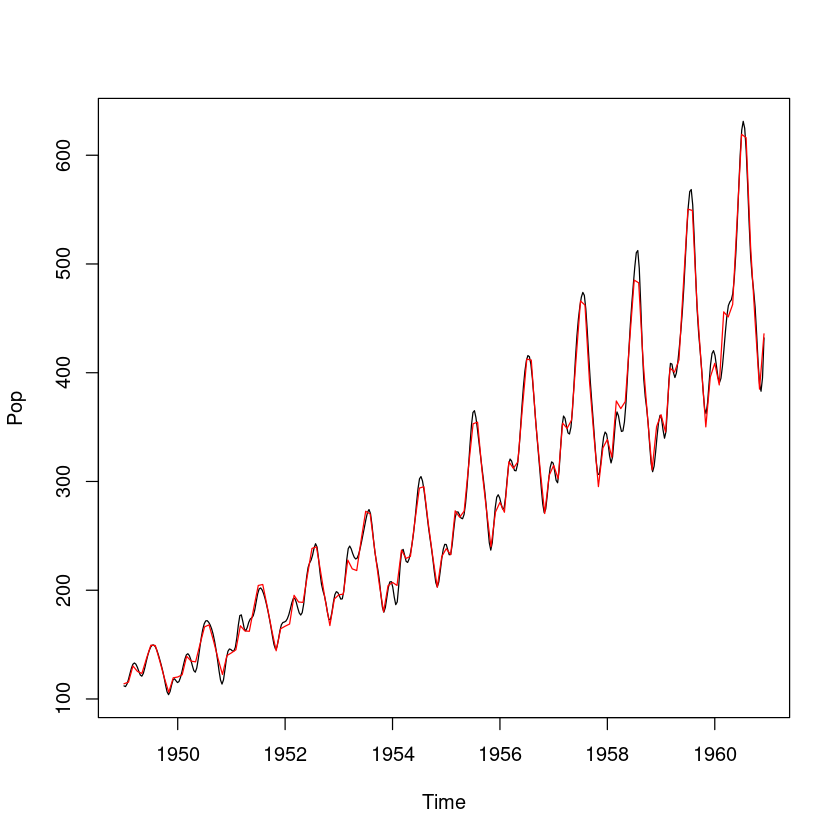

In [184]:
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

# 원 데이터 및 fitted 데이터의 비교
# BoxCox 역변환 필요 함
lines(InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)), col='red')
#mean((origin - InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)))^2, na.rm = TRUE)

`-` 방법3

In [187]:
# 회귀 모형 생성
# 모형식 : tran_org=trend∗β1+M1∗d1+...+M11∗d11+ϵ
model_stl <- lm(formula = tran_org~ time(tran_org)+stl_tran_org_df$trend+stl_tran_org_df$seasonal, na.action = NULL)
summary(model_stl)


Call:
lm(formula = tran_org ~ time(tran_org) + stl_tran_org_df$trend + 
    stl_tran_org_df$seasonal, na.action = NULL)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0177582 -0.0021157 -0.0002719  0.0030251  0.0138833 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.1642334  1.5824743   1.368    0.174    
time(tran_org)           -0.0011787  0.0008586  -1.373    0.172    
stl_tran_org_df$trend     1.0513689  0.0356252  29.512   <2e-16 ***
stl_tran_org_df$seasonal  1.0087073  0.0178209  56.602   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00519 on 140 degrees of freedom
Multiple R-squared:  0.9966,	Adjusted R-squared:  0.9965 
F-statistic: 1.352e+04 on 3 and 140 DF,  p-value: < 2.2e-16


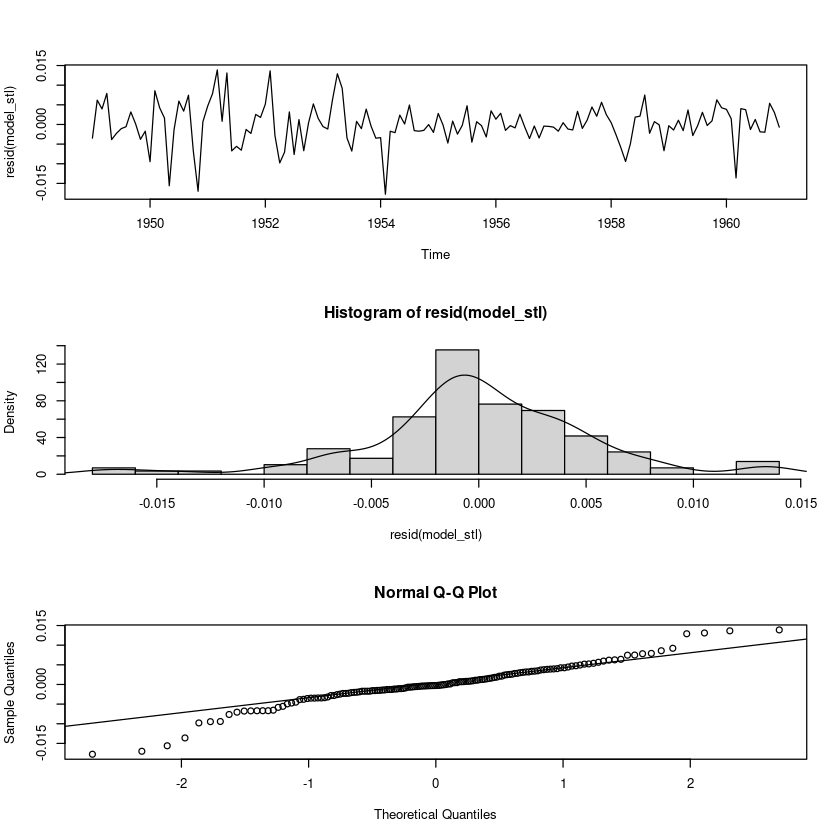

In [188]:
# 잔차 검정
par(mfrow=c(3,1))
# time Plot
plot(resid(model_stl))
# Hist Plot
hist(resid(model_stl),prob=TRUE,12)
lines(density(resid(model_stl)))
# Q-Q PLOT
qqnorm(resid(model_stl))
qqline(resid(model_stl))
# Q-Q Plot과 Histogram을 확인하면 양쪽 끝이 두텁지만 White Noise라고 판단하기 어려움이 없음


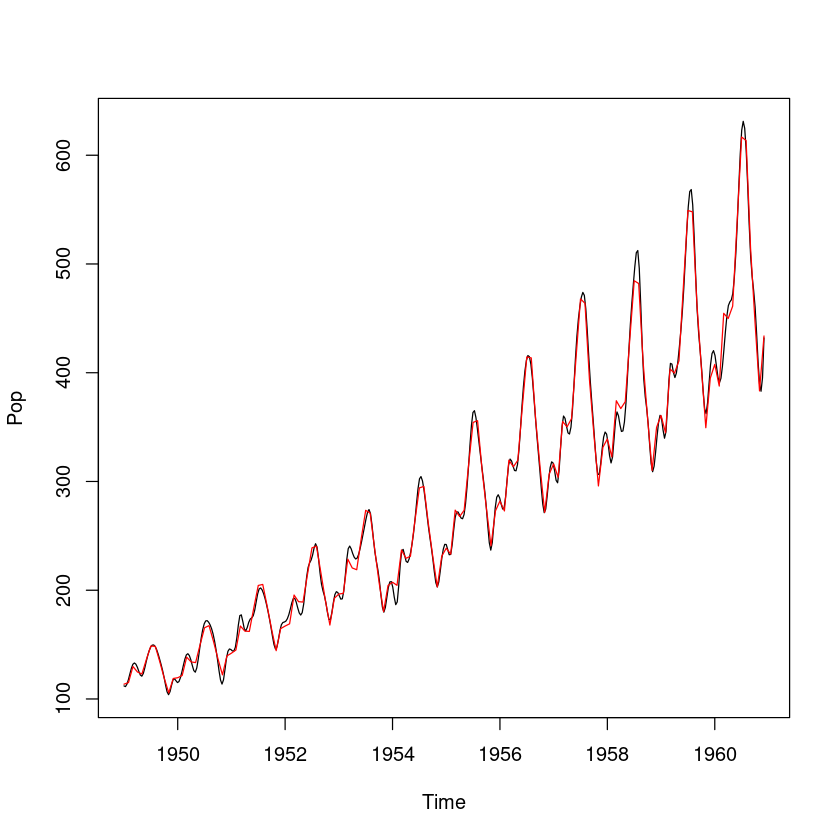

In [189]:
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

# 원 데이터 및 fitted 데이터의 비교
# BoxCox 역변환 필요 함
lines(InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)), col='red')
#mean((origin - InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)))^2, na.rm = TRUE)

# 지수평활을 이용한 예측

- 단순 지수 평활: 추세나 계절적 변동이 없는 시계열 예측에 사용
- 이중 지수 평활: 추세만 존재하는 시계열 예측에 사용
- HoltWinters: 추세와 계절 요인이 있는 시계열 예측에 사용

이중 지수 평활을 확장한 개념으로 특정 기간 내의 계절성을 함께 고려 가능

`-` 더하는 모형 

$Y_t = T_t + S_t + {\tt 오차}$

In [219]:
t = (1:120/120)*10
s = rep(c(1,2,3,4,5,6,7,6,5,4,3,2),10)
e = rnorm(120)*0.9

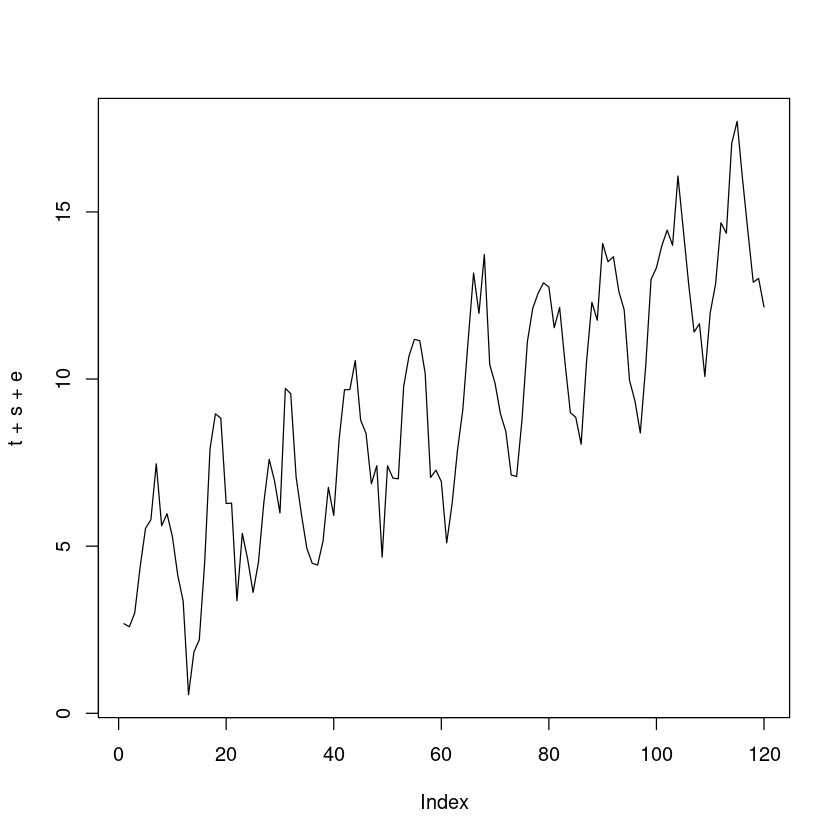

In [220]:
plot(t+s+e,type='l')

`-` 곱하는 모형 

$Y_t = T_t * S_t + {\tt 오차}$

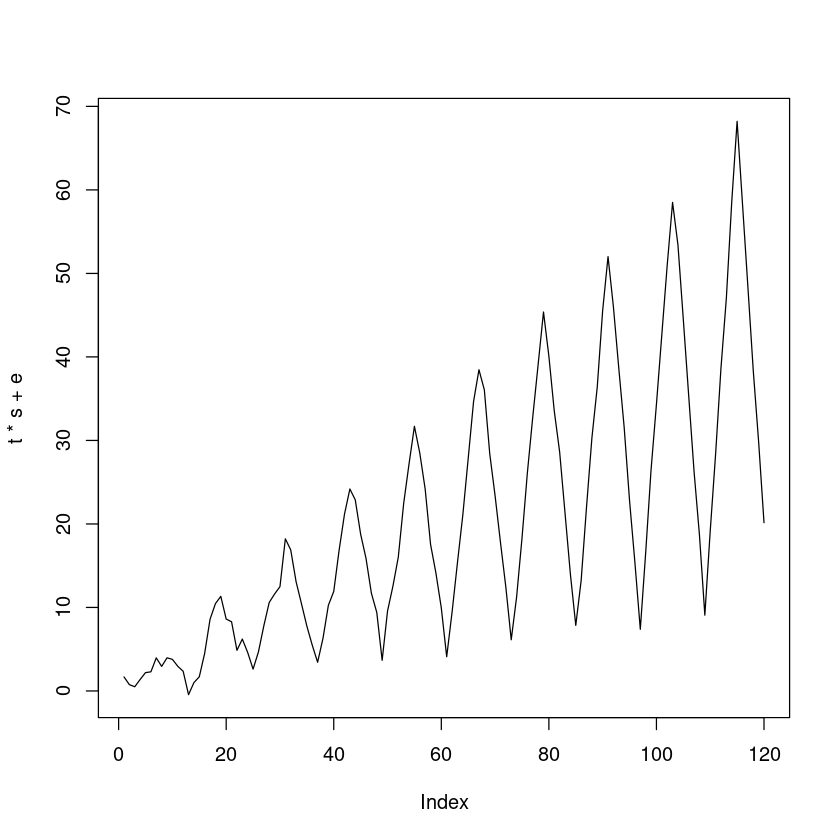

In [221]:
plot(t*s+e,type='l')

얘는 t랑 s를 엄청 잘찾으면 분산안정화가 필요없음 

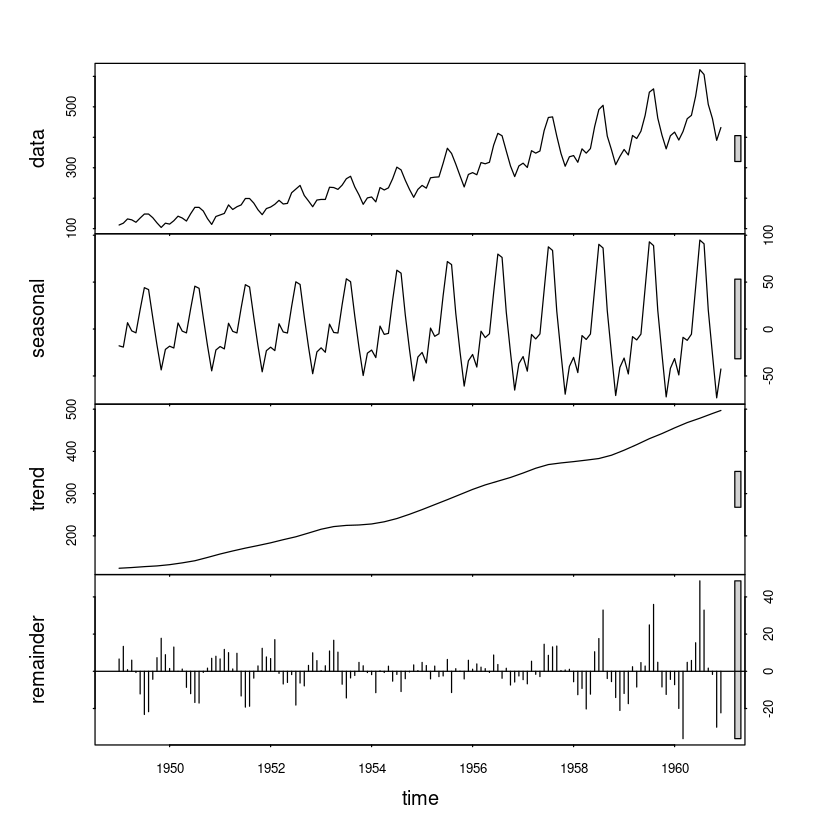

In [33]:
#============================================================
# 지수평활을 이용한 예측
#============================================================

plot(stl(origin, s.window=12))
# Trend 및 Seasonality 존재
# Holt-Winter 지수평활 모형이 적합

[1] 125.5362

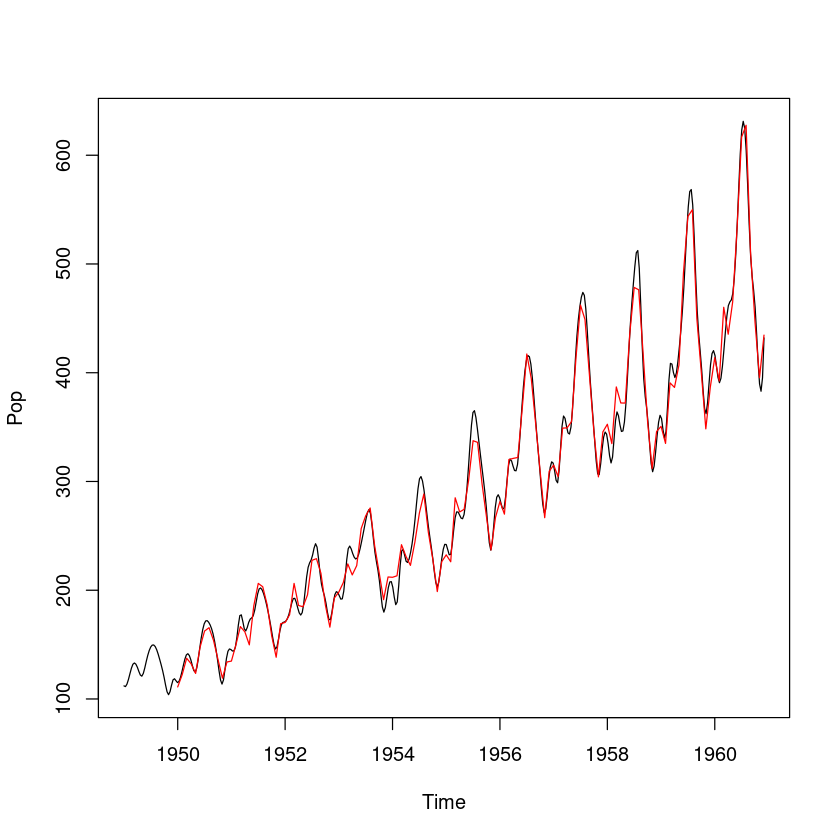

In [34]:
#HoltWinters 모형 생성
model_es <- HoltWinters(origin, seasonal = "multiplicative")

# 원 데이터 및 fitted 데이터의 비교
# plot
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')
lines(model_es$fitted[,1], col='red')
# mse 125.5
mean((origin-model_es$fitted[,1])^2)

`-` 또다른방법

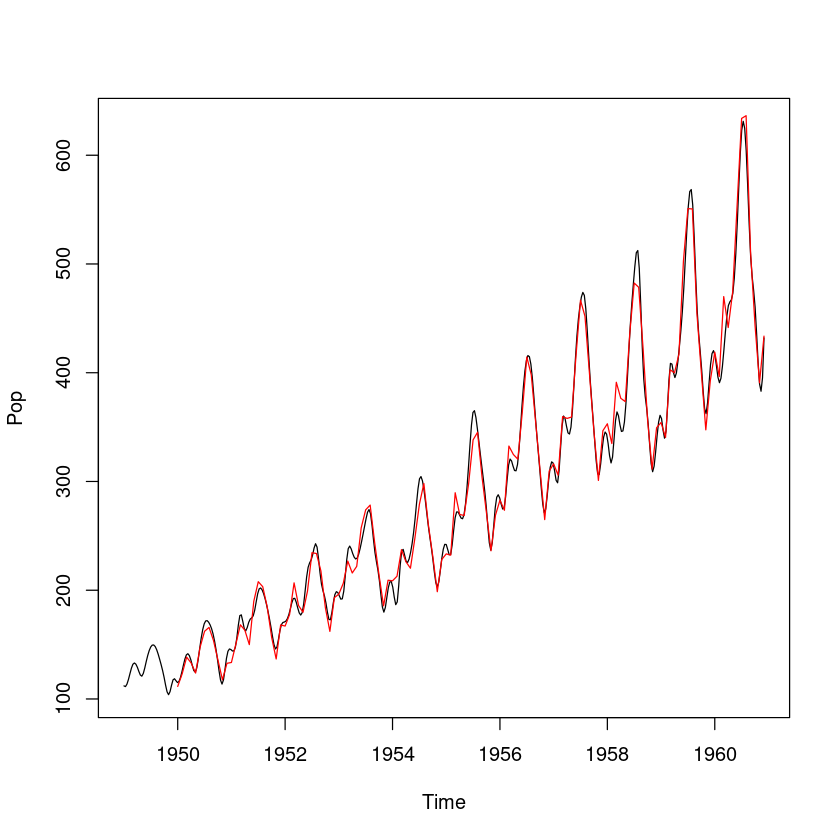

In [236]:
#HoltWinters 모형 생성
model_es <- HoltWinters(tran_org, seasonal = "additive")

# 원 데이터 및 fitted 데이터의 비교
# plot
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')
lines(InvBoxCox(model_es$fitted[,1], lambda = BoxCox.lambda(origin)), col='red')
# mse 125.5
#mean((tran_org-model_es$fitted[,1])^2)

# ARIMA를 이용한 예측

- Seasonality 제거/ 차분인데 시즈널리티가 뚜렷하면 시즈널 제거...

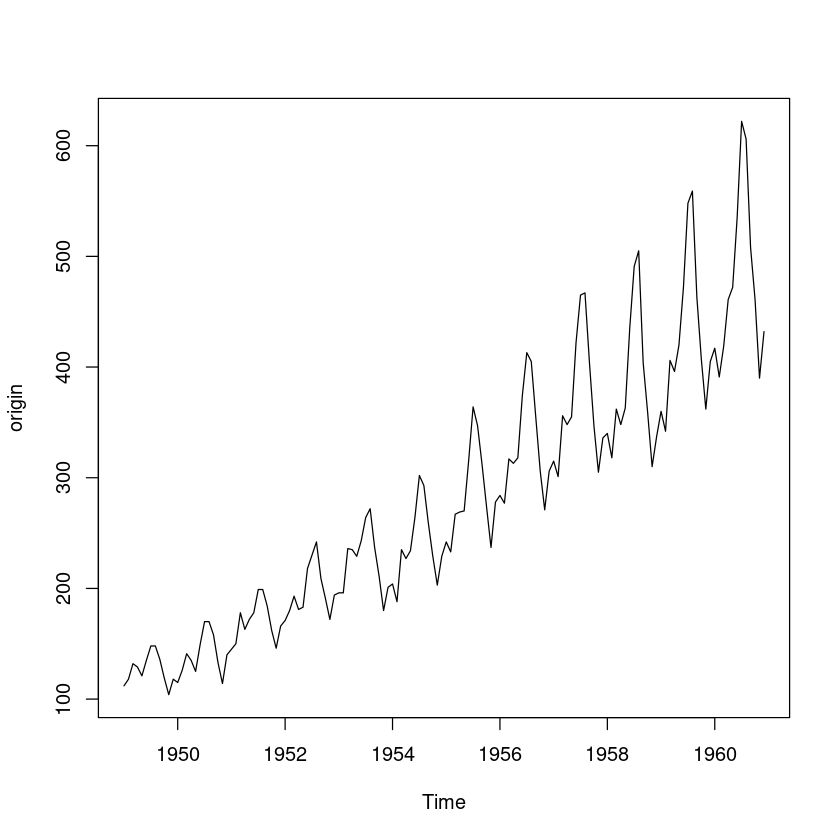

In [35]:
# 데이터 탐색 및 모형식별
# 시도표
plot(origin)
# 데이터의 이분산과 1차 추세가 존재함
# 분산 안정화를 위한 Box Cox 변환과 1차 차분 필요

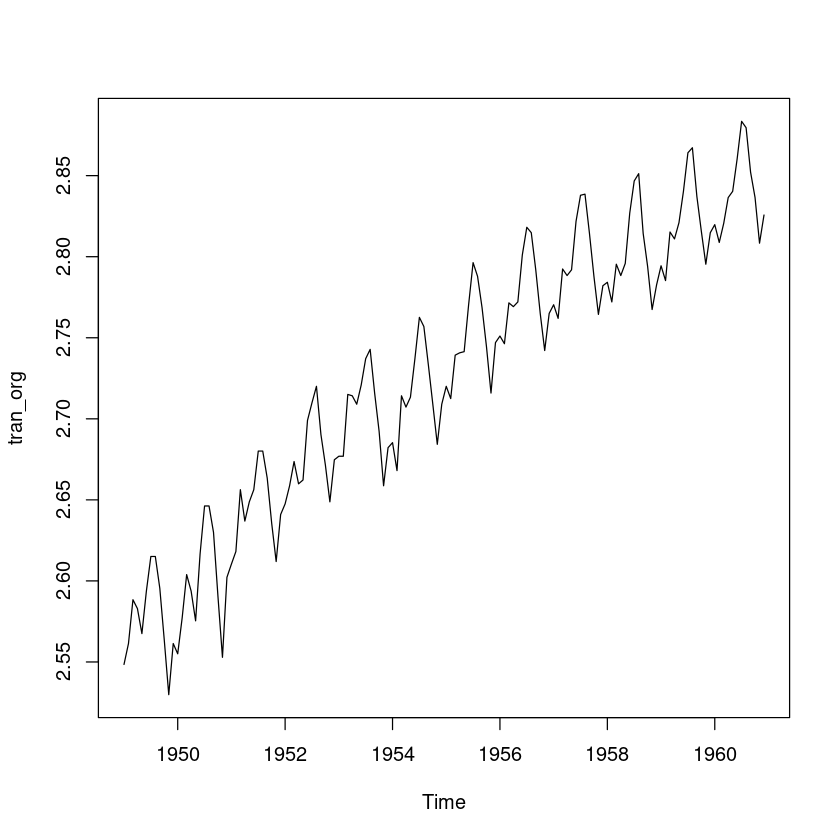

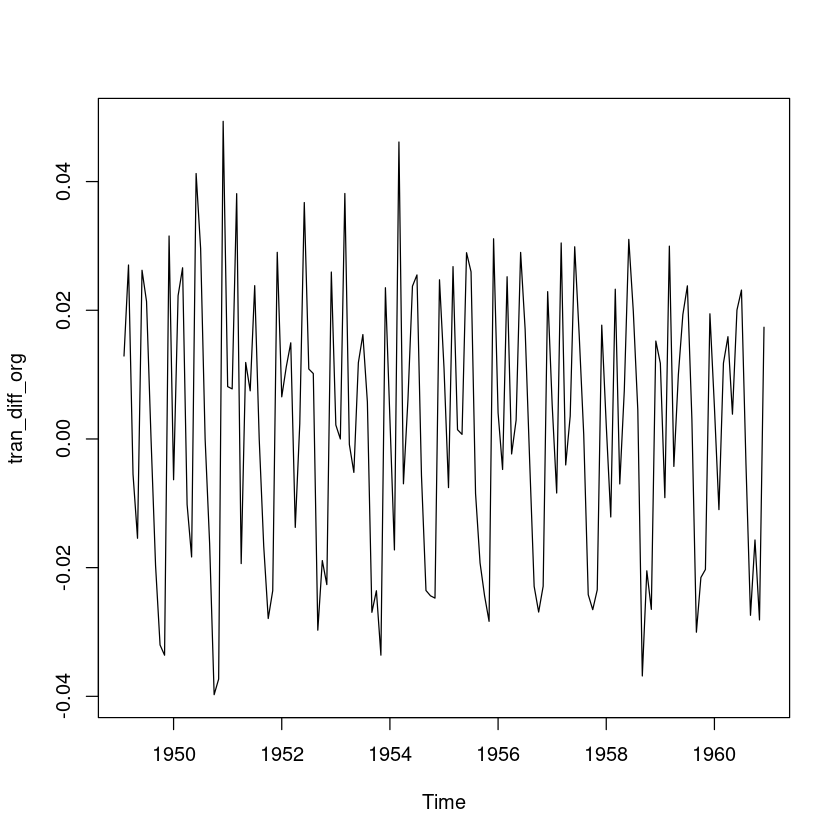

In [36]:
# 분산 안정화 및 차분
tran_org <- BoxCox(origin, BoxCox.lambda(origin))
plot(tran_org)
tran_diff_org <- diff(tran_org)
plot(tran_diff_org)

- 계절성을 먼저 제거하고 차분을 해야하는 케이스가 존재.
- 일반적으로는 차분을 먼저한다. 

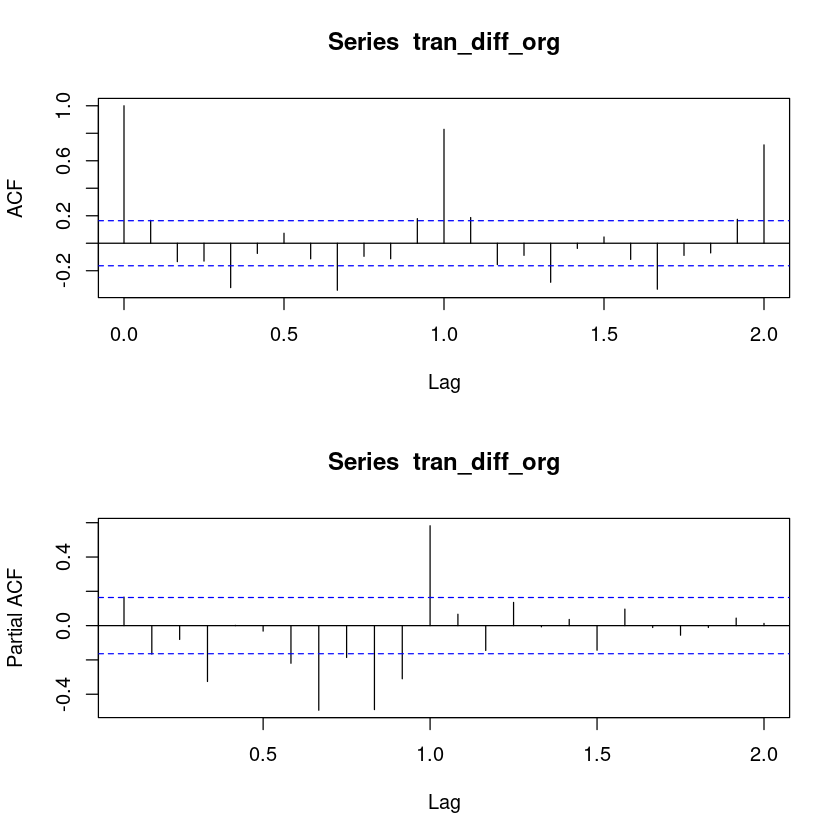

In [37]:
# ACF, PACF를 통한 탐색
layout(1:2)
acf(tran_diff_org, lag.max = 24)
pacf(tran_diff_org, lag.max=24)

In [38]:
# 계절 차분 및 ACF, PACF를 통한 탐색
tran_sdiff_org <- diff(tran_diff_org, lag = 12)

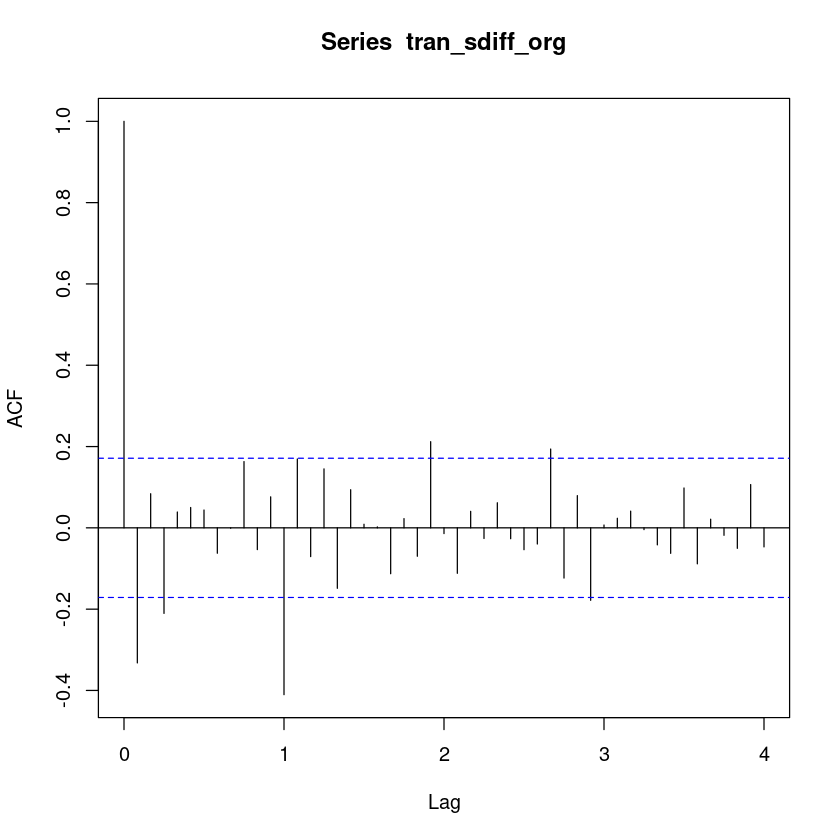

In [237]:
acf(tran_sdiff_org, lag.max = 48)
# acf는 lag=1,3,12에서 0이 아닌값 가짐  비계절 시차 4부터 절단 -> MA(3), 계절 -> 시차 2부터 절단 SMA(1)

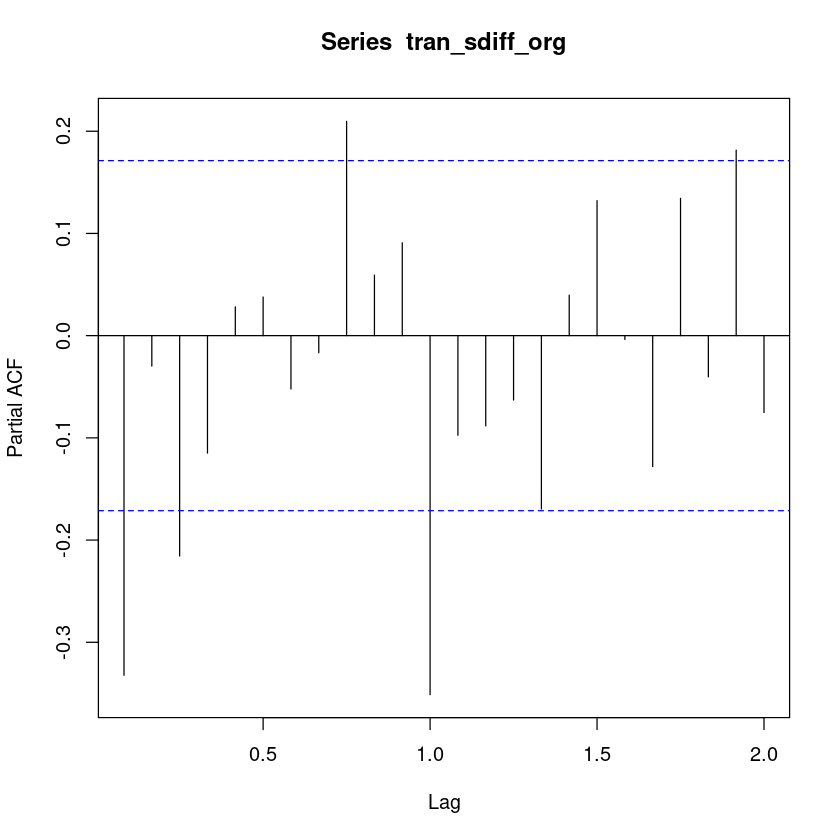

In [40]:
pacf(tran_sdiff_org, lag.max = 24)
# 시차 2와 8에서 0보다 큰 값을 가지지만 정확한 모형을 찾기 위해 auto.arima를 통해 aic가 최소가 되는 order 값 구함

In [246]:
auto.arima(tran_sdiff_org, max.p = 3, max.q=3, max.Q=1)
auto.arima(tran_org, max.p = 3, max.q=3, max.Q=1)
# 모형 구축

Series: tran_sdiff_org 
ARIMA(0,0,1)(0,0,1)[12] with zero mean 

Coefficients:
          ma1     sma1
      -0.4355  -0.5847
s.e.   0.0908   0.0725

sigma^2 = 5.789e-05:  log likelihood = 451.59
AIC=-897.18   AICc=-896.99   BIC=-888.55

Series: tran_org 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4355  -0.5847
s.e.   0.0908   0.0725

sigma^2 = 5.855e-05:  log likelihood = 451.6
AIC=-897.19   AICc=-897.01   BIC=-888.57

In [247]:
model_arima <- arima(tran_sdiff_org, order=c(0,0,1), seasonal = list(order = c(0,0,1), period = 12))
model_arima <- arima(tran_org, order=c(0,1,1), seasonal = list(order = c(0,1,1), period = 12))

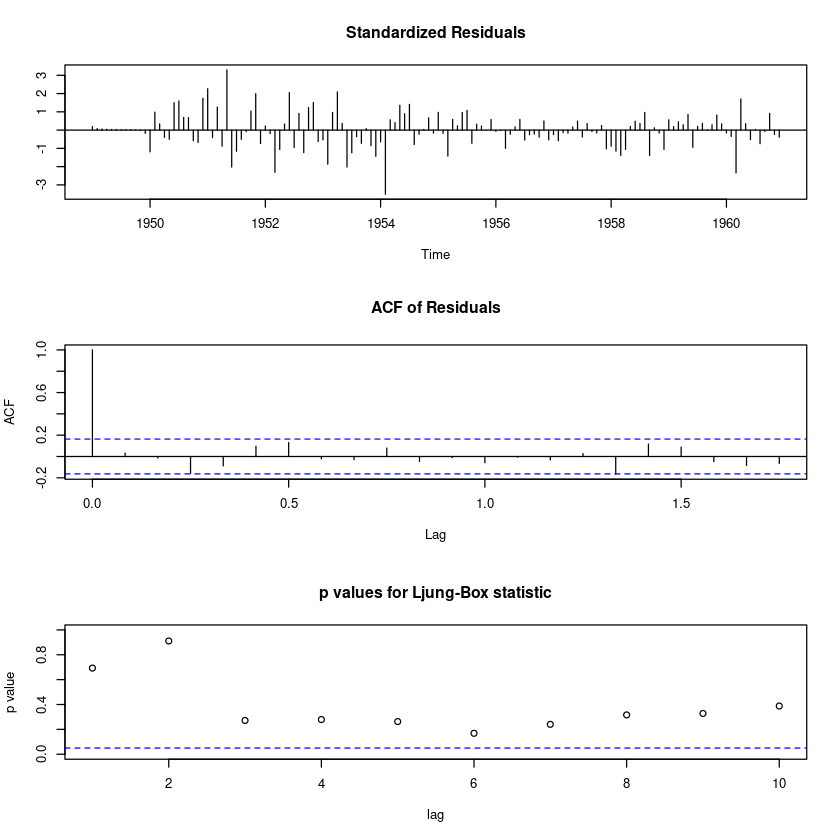

In [248]:
# 모형 검진
# 잔차 검정
tsdiag(model_arima)
# 독립성 검정

In [249]:
Box.test(model_arima$residuals, type="Ljung-Box")
# 잔차의 독립성, 등분산성, 정규성 만족


	Box-Ljung test

data:  model_arima$residuals
X-squared = 0.15595, df = 1, p-value = 0.6929


plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

In [45]:
# spline ? underline function을 부드럽게 만드는 함수...

[1] 107.2414

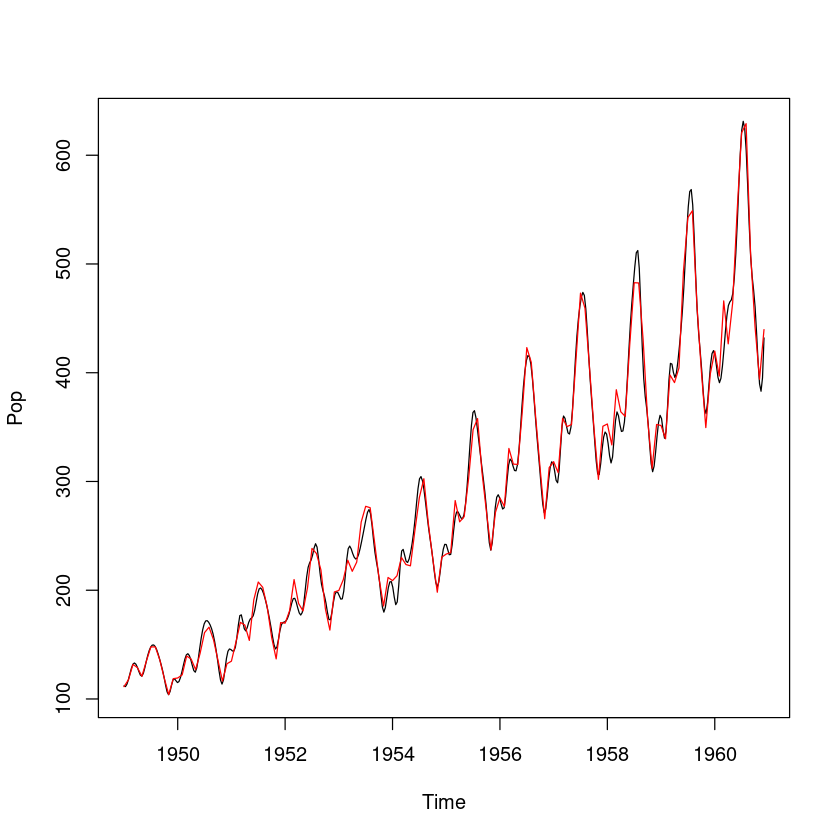

In [46]:
# 원 데이터 및 fitted 데이터의 비교
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')
lines(InvBoxCox(fitted(model_arima), BoxCox.lambda(origin)), col='red')
mean((origin - InvBoxCox(fitted(model_arima), BoxCox.lambda(origin)))^2)

In [47]:
# 12개월 예측
arima_fit <- predict(model_arima, n.ahead=12) #BoxCox 변환 데이터 사용
lambda <- BoxCox.lambda(origin)

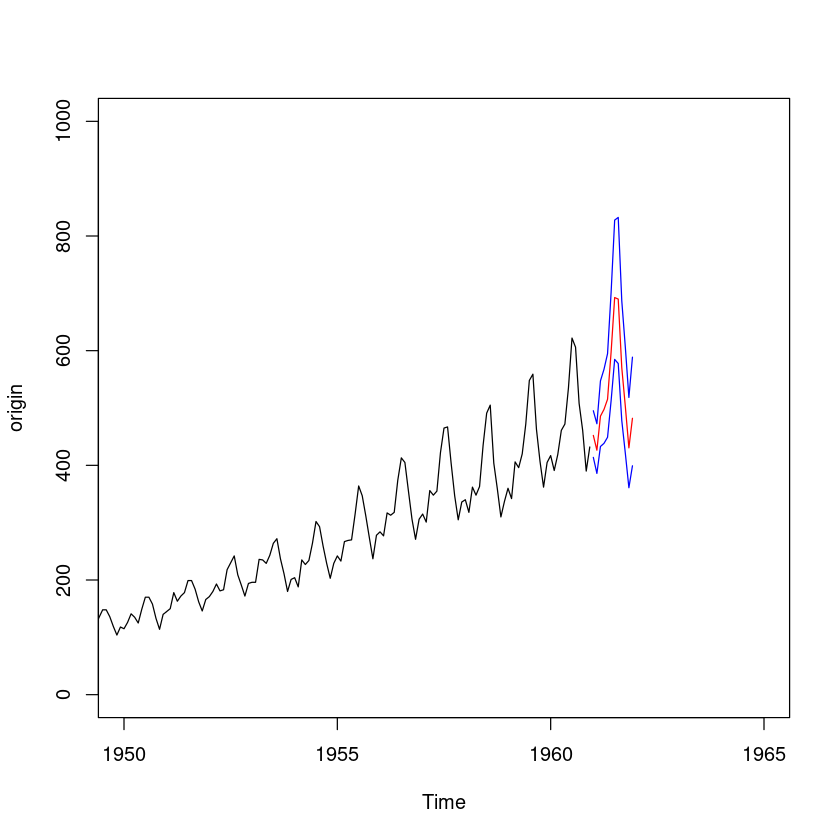

In [48]:
ts.plot(origin, xlim=c(1950,1965), ylim = c(0, 1000))
lines(InvBoxCox(arima_fit$pred, lambda),col="red")
lines(InvBoxCox(arima_fit$pred+1.96*arima_fit$se, lambda),col="blue",lty=1)
lines(InvBoxCox(arima_fit$pred-1.96*arima_fit$se, lambda),col="blue",lty=1)